# Landslide Detection

## Block 1: Import Libraries

In [48]:
# Import necessary libraries
import os
import plotly.express as px
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, f1_score, make_scorer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import lightgbm as lgb
from lightgbm import LGBMClassifier
from optuna.samplers import RandomSampler
from sklearn.metrics import f1_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from xgboost import XGBClassifier
import optuna
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.metrics import f1_score, accuracy_score
import plotly.graph_objects as go
from plotly.subplots import make_subplots

## Define Paths and Load CSV Files

In [2]:
# Define paths for the dataset (remember to unzip the dataset first!)
train_csv_path = '/kaggle/input/landslide-detection/Train.csv'  # Path to the training labels CSV file
test_csv_path = '/kaggle/input/landslide-detection/Test.csv'    # Path to the test image IDs CSV file
train_data_path = '/kaggle/input/landslide-detection/train_data/train_data'  # Folder where .npy train files are located
test_data_path = '/kaggle/input/landslide-detection/test_data/test_data'    # Folder where .npy test files are located

# Load Train.csv and inspect the data
train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)
print("Train.csv:")
print(train_df.head())

Train.csv:
          ID  label
0  ID_HUD1ST      1
1  ID_KGE2HY      1
2  ID_VHV9BL      1
3  ID_ZT0VEJ      0
4  ID_5NFXVY      0


In [86]:
train_df.label.value_counts(normalize=True)

label
0    0.824402
1    0.175598
Name: proportion, dtype: float64

### Explanation
- The images are heavily imbalanced with the class 0 images accounting for 82% of the data while class 1 accounts for 18%.


## Data Preparation

This step will include loading the .npy files into one array with shape `[no of files, height, width, no of bands]`. 

In [ ]:
def load_image(image_id, folder_path):
    """
    Loads a .npy image file from disk as a float32 NumPy array.
    """
    # Build the full path to the image file
    image_path = os.path.join(folder_path, f"{image_id}.npy")
    
    # Load the image using memory-mapped mode ('r') to reduce memory usage
    img = np.load(image_path, mmap_mode='r')
    
    # Convert the data type to float32 for efficient computation
    img = img.astype('float32')
    
    return img


# Load all training images into a single NumPy array
X = np.array([
    load_image(image_id, train_data_path) 
    for image_id in train_df['ID']
])

# Load all test images into a single NumPy array
X_test_arrays = np.array([
    load_image(image_id, test_data_path) 
    for image_id in test_df['ID']
])

# Extract the target labels from the training dataframe
y = train_df['label'].values

## Feature Engineering

In this step, we will create new features that will hopefully increase the model’s performance by providing it with more informative and relevant inputs, capturing hidden patterns in the data, and improving its ability to generalize to unseen samples.

### Engineered Features

We create four new features from the original 12-band imagery:

1. **NDVI (Normalized Difference Vegetation Index)**  
   Measures vegetation health and density. Higher NDVI values indicate more vigorous vegetation.  

   $$
   \text{NDVI} = \frac{\text{NIR} - \text{Red}}{\text{NIR} + \text{Red} + \epsilon}
   $$

2. **NDWI (Normalized Difference Water Index)**  
   Enhances water-related features, useful for detecting water bodies and moisture content.  

   $$
   \text{NDWI} = \frac{\text{Green} - \text{NIR}}{\text{Green} + \text{NIR} + \epsilon}
   $$

3. **VV/VH Ratio (Descending pass)**  
   Captures surface scattering properties from the radar descending orbit. Useful for distinguishing vegetation, bare soil, and urban areas.  

   $$
   \text{Ratio}_{\text{desc}} = \frac{\text{VV}_{\text{desc}}}{\text{VH}_{\text{desc}} + \epsilon}
   $$

4. **VV/VH Ratio (Ascending pass)**  
   Same as above, but from the ascending orbit to provide complementary radar perspective.  

   $$
   \text{Ratio}_{\text{asc}} = \frac{\text{VV}_{\text{asc}}}{\text{VH}_{\text{asc}} + \epsilon}
   $$

---

**Final Output:**  
- **Original channels:** 12  
- **New engineered features:** 4  
- **Total channels:** 16  
- Shape: **(batch, H, W, 16)**


In [5]:
def extract_features(img):
    # img: (batch, H, W, 12)

    # Bands 1-4: Optical
    red, green, blue, nir = [img[:, :, :, i] for i in range(4)]
    ndvi = (nir - red) / (nir + red + 1e-5)
    ndwi = (green - nir) / (green + nir + 1e-5)

    # Radar Descending
    vv_desc, vh_desc = img[:, :, :, 4], img[:, :, :, 5]
    vv_vh_ratio_desc = (vv_desc + 1e-5) / (vh_desc + 1e-5)

    # Radar Ascending
    vv_asc, vh_asc = img[:, :, :, 8], img[:, :, :, 9]
    vv_vh_ratio_asc = (vv_asc + 1e-5) / (vh_asc + 1e-5)

    # Expand NDVI etc. to (batch, H, W, 1) before concatenation
    ndvi = ndvi[..., np.newaxis]
    ndwi = ndwi[..., np.newaxis]
    vv_vh_ratio_desc = vv_vh_ratio_desc[..., np.newaxis]
    vv_vh_ratio_asc = vv_vh_ratio_asc[..., np.newaxis]

    # Concatenate along channel axis
    features = np.concatenate([img, ndvi, ndwi, vv_vh_ratio_desc, vv_vh_ratio_asc], axis=-1)
    return features

X_features = extract_features(X)
X_test_features = extract_features(X_test_arrays)

The next step is to take the image data (with multiple spectral and engineered feature bands) and summarize each band into tabular statistics.
This will transform high-dimensional image tensors into compact numerical features that can be fed into models like XGBoost, LightGBM, RandomForest, or linear models — instead of CNNs.

In [6]:
from scipy.stats import kurtosis, skew
def means(df, X):
    df1 = df.copy()

    # Bands 1 to 12
    for band in range(12):
        data = X[:, :, :, band]
        df1[f'band{band+1}_mean'] = data.mean(axis=(1, 2))
        df1[f'band{band+1}_std']  = data.std(axis=(1, 2))
        df1[f'band{band+1}_min']  = data.min(axis=(1, 2))
        df1[f'band{band+1}_max']  = data.max(axis=(1, 2))
        df1[f'band{band+1}_kurt'] = kurtosis(data, axis=(1, 2), fisher=True)
        df1[f'band{band+1}_skew'] = skew(data, axis=(1, 2))

    # NDVI and NDWI (bands 13, 14 in X)
    for name, idx in zip(['ndvi', 'ndwi'], [12, 13]):
        data = X[:, :, :, idx]
        df1[f'{name}_mean'] = data.mean(axis=(1, 2))
        df1[f'{name}_std']  = data.std(axis=(1, 2))
        df1[f'{name}_min']  = data.min(axis=(1, 2))
        df1[f'{name}_max']  = data.max(axis=(1, 2))
        df1[f'{name}_kurt'] = kurtosis(data, axis=(1, 2), fisher=True)
        df1[f'{name}_skew'] = skew(data, axis=(1, 2))

    return df1

# Apply to training dataframe
training_df = means(train_df, X_features)
testing_df = means(test_df, X_test_features)

## Feature Selection

In [30]:
# CHeck the shape of the data
training_df.shape

(7147, 86)

The dataset contains a total of 86 features, some of which may be noisy or irrelevant and could negatively impact model performance. To address this, we will perform feature selection using `SelectFromModel` to retain only the most informative features and reduce the risk of overfitting.


In [7]:
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBClassifier

# Model for feature selection
lgb_model = XGBClassifier(random_state=42)

# Separate features and target
X_df = training_df.drop(columns=['ID', 'label'])
y_df = training_df['label']

# Select features above median importance
selector = SelectFromModel(lgb_model, threshold='median', prefit=False)
selector.fit(X_df, y_df)

# Get selected feature names
selected_features = X_df.columns[selector.get_support()]

# Keep only selected features
X_selected = X_df[selected_features]

Next, let's get a visualization of the feature importances

In [33]:
# Get feature importances from the fitted model inside SelectFromModel
importances = selector.estimator_.feature_importances_

# Put into DataFrame for easy plotting
feat_df = pd.DataFrame({
    "Feature": X_df.columns,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# Plot interactive bar chart
fig = px.bar(
    feat_df,
    x="Feature",
    y="Importance",
    title="Feature Importances",
    labels={"Importance": "Importance Score"},
)
fig.update_layout(xaxis_tickangle=-90)
fig.show()


## Modelling

A total of four models will be used which include:
* XGBoost
* LightGBM
* Stacking classifier
* Voting classifier of the two

Cross validation will be used as the go-to method for evaluating the models. The main metric that will be used in evaluation will be F1-Score

### XGBoost

In [37]:
# Split data into train and test samples
X_train, X_test, y_train, y_test = train_test_split(X_selected, y_df, stratify=y_df, random_state=42)

# Instantiate the xgb model and fit to training data
xgb =XGBClassifier(random_state=42)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [74]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, f1_score, accuracy_score
from sklearn.model_selection import StratifiedKFold
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np

def cross_validate_model(model, X_train, y_train, threshold=0.5, n_splits=5, random_state=42):
    """
    Perform Stratified K-Fold CV, average predictions for test set, and plot ROC + Confusion Matrix.
    """

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    y_test_preds = []
    f1_scores, acc_scores = [], []
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
        print(f"Fold {fold+1}/{n_splits}")
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # Fit model
        model.fit(X_tr, y_tr)
        
        # Predict validation
        y_val_pred = model.predict(X_val)
        
        # Predict test probabilities
        preds_proba = model.predict_proba(X_test)[:, 1]
        y_test_preds.append(preds_proba)

        # Metrics
        f1 = f1_score(y_val, y_val_pred)
        acc = accuracy_score(y_val, y_val_pred)
        f1_scores.append(f1)
        acc_scores.append(acc)
        
        print(f"Fold {fold+1} F1: {f1:.4f} | Accuracy: {acc:.4f}")

    # Average predictions for test set
    y_test_preds = np.array(y_test_preds)
    final_probs = y_test_preds.mean(axis=0)
    final_preds = (final_probs > threshold).astype(int)
    
    print("="*40)
    print(f"Mean F1 Score: {np.mean(f1_scores):.4f}")
    print(f"Mean Accuracy: {np.mean(acc_scores):.4f}")

    # ROC curve
    fpr, tpr, _ = roc_curve(y_test, final_probs)
    roc_auc = auc(fpr, tpr)

    # Confusion matrix
    cm = confusion_matrix(y_test, final_preds)
    cm_sum = cm.sum(axis=1, keepdims=True)
    cm_perc = cm.astype(float) / cm_sum * 100

    # Subplot layout
    fig = make_subplots(
        rows=2, cols=1,
        subplot_titles=(f"ROC Curve (AUC = {roc_auc:.2f})", "Confusion Matrix"),
        vertical_spacing=0.2
    )

    # ROC trace
    roc_curve_trace = go.Scatter(
        x=fpr, y=tpr,
        mode='lines',
        name='ROC curve',
        line=dict(color='blue')
    )
    diag_line = go.Scatter(
        x=[0, 1], y=[0, 1],
        mode='lines',
        name='Random Guess',
        line=dict(color='green', dash='dash')
    )

    fig.add_trace(roc_curve_trace, row=1, col=1)
    fig.add_trace(diag_line, row=1, col=1)

    # Confusion Matrix heatmap
    heatmap = go.Heatmap(
        z=cm,
        x=["Pred 0", "Pred 1"],
        y=["True 0", "True 1"],  # sklearn convention
        text=cm,
        texttemplate="%{text}",
        colorscale="Blues",
        showscale=True,
        colorbar=dict(orientation="h", y=-0.25)
    )
    fig.add_trace(heatmap, row=2, col=1)

    # Axis labels
    fig.update_xaxes(title_text="False Positive Rate", row=1, col=1)
    fig.update_yaxes(title_text="True Positive Rate", row=1, col=1)
    fig.update_xaxes(title_text="Predicted Label", row=2, col=1)
    fig.update_yaxes(title_text="True Label", row=2, col=1, autorange="reversed")

    # Layout
    fig.update_layout(height=1200, width=650, showlegend=True)
    fig.show()

    return final_probs

# Example usage
Xgboost_preds = cross_validate_model(xgb, X_train, y_train)


Fold 1/5
Fold 1 F1: 0.8347 | Accuracy: 0.9450
Fold 2/5
Fold 2 F1: 0.8442 | Accuracy: 0.9487
Fold 3/5
Fold 3 F1: 0.8343 | Accuracy: 0.9459
Fold 4/5
Fold 4 F1: 0.8571 | Accuracy: 0.9515
Fold 5/5
Fold 5 F1: 0.8219 | Accuracy: 0.9394
Mean F1 Score: 0.8385
Mean Accuracy: 0.9461


### Hyperparameter Tuning

**Optuna** will be used to automatically search for the best XGBoost hyperparameters that maximize the F1 score on the validation set.  
Optuna was chosen over GridSearchCV because it uses smarter search strategies (e.g., Tree-structured Parzen Estimators) that explore promising regions of the parameter space efficiently, making it much faster and less computationally expensive.

In [ ]:
def objective(trial):
    # Define hyperparameter search space
    params = {
        "max_depth": trial.suggest_int("max_depth", 3, 12),  # Tree depth
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),  # Step size
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),  # Row sampling
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),  # Feature sampling
        "min_child_weight": trial.suggest_float("min_child_weight", 1, 10),  # Min samples per leaf
        "gamma": trial.suggest_float("gamma", 0, 5),  # Min loss reduction
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True),  # L2 regularization
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 1.0, log=True),  # L1 regularization
        "random_state": 42,
    }

    f1_scores = []

    # Train model with current params
    model = XGBClassifier(**params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=False
    )

    # Predict and calculate F1 score
    y_pred = model.predict(X_val)
    f1_scores.append(f1_score(y_val, y_pred))

    # Return mean F1 score
    return np.mean(f1_scores)


# Suppress Optuna logs
optuna.logging.set_verbosity(optuna.logging.CRITICAL)

# Create and run Optuna study
xgb_study = optuna.create_study(direction="maximize")
xgb_study.optimize(objective, n_trials=50)

# Show best results
print("Best F1:", xgb_study.best_value)
print("Best Params:", xgb_study.best_params)


In [83]:
# Instantiate a new model with the params from Optuna
best_xgb = XGBClassifier(**xgb_study.best_params)

# Crosss validate the new model
xgb_tuned_preds = cross_validate_model(best_xgb, X_train, y_train)

Fold 1/5
Fold 1 F1: 0.8199 | Accuracy: 0.9394
Fold 2/5
Fold 2 F1: 0.8427 | Accuracy: 0.9478
Fold 3/5
Fold 3 F1: 0.8555 | Accuracy: 0.9524
Fold 4/5
Fold 4 F1: 0.8389 | Accuracy: 0.9459
Fold 5/5
Fold 5 F1: 0.8066 | Accuracy: 0.9347
Mean F1 Score: 0.8327
Mean Accuracy: 0.9440


After getting the best parameters for the model, the next step will be to tune the classification threshold.
While most classifiers use a default threshold of 0.5 for converting predicted probabilities into class labels, this default may not yield the best balance between precision and recall, especially in imbalanced datasets.
By adjusting the threshold, we can target a higher F1 score, optimize for recall to reduce false negatives, or improve precision to reduce false positives,

In [79]:
def threshold_tuning(model, y_test, y_test_proba):
    scores = []  # Store F1 scores for each threshold
    thresholds = np.linspace(0.1, 1, 10)  # Range of thresholds to test

    for thresh in thresholds:
        y_pred = y_test_proba
        y_tuned = (y_pred > thresh).astype(int)  # Convert probabilities to binary predictions
        scores.append(f1_score(y_test, y_tuned))  # Compute F1 score for current threshold

    # Create line plot of threshold vs F1 score
    fig = px.line(x=thresholds, y=scores, title='Threshold Tuning', template='plotly_white')
    fig.update_traces(line=dict(color='red'))
    fig.update_layout(xaxis_title='Thresholds',
                      yaxis_title='F1 Scores',
                      height=500,
                      width=800)
    
    fig.show()

# Run threshold tuning on validation data
threshold_tuning(best_xgb, y_test, xgb_tuned_preds)


The best threshold that yields the highest F2-Score for this model is 0.4.

The final step is to use **SHAP** (SHapley Additive exPlanations) to gain a deeper understanding of the features that contributed the most to the model’s predictions.

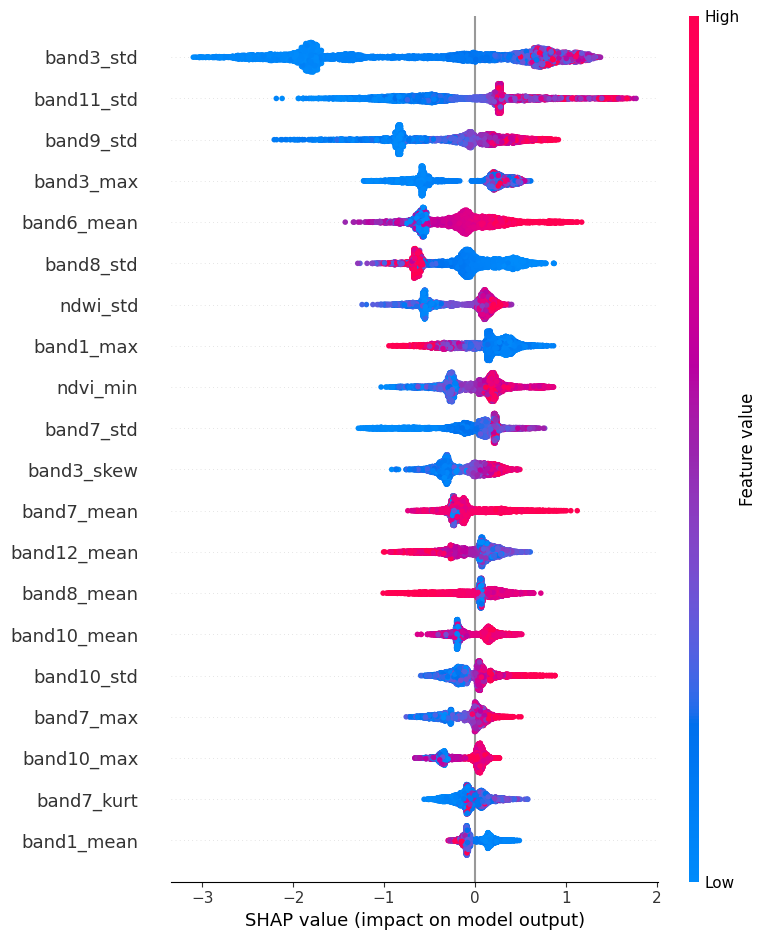

In [80]:
import shap  # Library for explainable AI (model interpretability)

# Create a SHAP explainer for the trained XGBoost model
explainer = shap.TreeExplainer(best_xgb)

# Calculate SHAP values for the training set
shap_values = explainer.shap_values(X_train)

# Generate a summary plot showing feature importance and impact on predictions
shap.summary_plot(shap_values, X_train)

## LightGB Model

LightGBM uses histogram-based gradient boosting and leaf-wise growth (best-first tree growth), which usually trains faster than XGBoost’s level-wise growth. Leaf-wise splitting can find deeper, more optimal splits, potentially increasing accuracy

In [15]:
# 1️⃣ Train LightGBM
lgb_model = LGBMClassifier(n_estimators=500, max_depth=-1, learning_rate=0.05)
lgb_model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 941, number of negative: 4419
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003011 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10710
[LightGBM] [Info] Number of data points in the train set: 5360, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.175560 -> initscore=-1.546726
[LightGBM] [Info] Start training from score -1.546726


LGBMClassifier(learning_rate=0.05, n_estimators=500)

In [82]:
# Cross validate the model
lgbm_preds = cross_validate_model(lgb_model, X_train, y_train)

Fold 1/5
Fold 1 F1: 0.8235 | Accuracy: 0.9412
Fold 2/5
Fold 2 F1: 0.8667 | Accuracy: 0.9552
Fold 3/5
Fold 3 F1: 0.8571 | Accuracy: 0.9534
Fold 4/5
Fold 4 F1: 0.8524 | Accuracy: 0.9506
Fold 5/5
Fold 5 F1: 0.8338 | Accuracy: 0.9431
Mean F1 Score: 0.8467
Mean Accuracy: 0.9487


### Hyperparameter Tuning

In [17]:
def objective(trial):
    # Define hyperparameter search space for LightGBM
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 200, 1000),   # Number of boosting rounds
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),  # Step size shrinkage
        "max_depth": trial.suggest_int("max_depth", 3, 15),             # Maximum depth of each tree
        "num_leaves": trial.suggest_int("num_leaves", 20, 100),         # Number of leaves in each tree
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),        # Fraction of data for bagging
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),  # Fraction of features for each tree
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 50),    # Minimum samples per leaf
        "verbose": -1                                                   # Suppress LightGBM output
    }

    # 5-fold stratified cross-validation setup (preserves class balance)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    f1_scores = []

    # Create LightGBM model with current trial's parameters
    model = LGBMClassifier(**params, random_state=42)

    # Train the model on training data with validation set
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],   # Validation data
        eval_metric='binary_logloss',
        callbacks=[]                 # No extra callbacks used
    )

    # Predict on validation data
    y_pred = model.predict(X_val)
    
    # Calculate F1 score for this trial
    f1_scores.append(f1_score(y_val, y_pred))

    # Return average F1 score from all folds (though here, only 1 is used)
    return np.mean(f1_scores)


# Disable Optuna's default verbose logging
optuna.logging.set_verbosity(optuna.logging.CRITICAL)

# Create an Optuna study to maximize F1 score
lgbm_study = optuna.create_study(direction="maximize")

# Run optimization for 50 trials
lgbm_study.optimize(objective, n_trials=50)

# Print best results
print("Best F1:", lgbm_study.best_value)
print("Best Params:", lgbm_study.best_params)


Best F1: 0.866115702479339
Best Params: {'n_estimators': 962, 'learning_rate': 0.034424218242917866, 'max_depth': 15, 'num_leaves': 94, 'subsample': 0.7833967031037726, 'colsample_bytree': 0.8061850603773909, 'min_child_samples': 37}


In [18]:
best_lgbm = LGBMClassifier(**lgbm_study.best_params)
cross_validate_model(best_lgbm, X_selected, y_df)

Fold 1/5
Fold 1 F1: 0.8606 | Accuracy: 0.9510 | Threshold: 0.2480
Fold 2/5
Fold 2 F1: 0.8502 | Accuracy: 0.9483 | Threshold: 0.2000
Fold 3/5
Fold 3 F1: 0.8784 | Accuracy: 0.9587 | Threshold: 0.4160
Fold 4/5
Fold 4 F1: 0.8915 | Accuracy: 0.9615 | Threshold: 0.2960
Fold 5/5
Fold 5 F1: 0.8661 | Accuracy: 0.9552 | Threshold: 0.5840
Mean F1 Score: 0.8693
Mean Accuracy: 0.9549


### Stacking Classifier

In [84]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

# Logistic Regression will serve as the meta-model (final estimator) 
# It will learn from the predictions of the base models.
logreg = LogisticRegression(random_state=42)

# Define a Stacking Classifier
# This combines multiple base learners (LightGBM and XGBoost here)
# and feeds their predictions into a final estimator (logistic regression).
stack = StackingClassifier(
    estimators=[
        ('lgbm', best_lgbm),  # First base learner: the best LightGBM model found
        ('xgb', best_xgb)     # Second base learner: the best XGBoost model found
    ],
    final_estimator=logreg,  # Meta-model for combining base learners' outputs
    cv=5,                    # 5-fold cross-validation for meta-model training
    verbose=1                # Print training progress
)

# Fit the stacking model on the full dataset
stack.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   30.2s finished
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.1s finished


StackingClassifier(cv=5,
                   estimators=[('lgbm',
                                LGBMClassifier(colsample_bytree=0.8061850603773909,
                                               learning_rate=0.034424218242917866,
                                               max_depth=15,
                                               min_child_samples=37,
                                               n_estimators=962, num_leaves=94,
                                               subsample=0.7833967031037726)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytr...
                                              learning_rate=0.09254764291940153,
                                              max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None, max_depth=8,
                                              max_leaves=None,
                                              min_child_weight=7.520969038519229,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=None, ...))],
                   final_estimator=LogisticRegression(random_state=42),
                   verbose=1)

In [ ]:
# Cross Validate the model
cross_validate_model(stack, X_train, y_train)

## Make Predictions on the Test Set and Prepare Submission

This step will involve preparing a function that performs 5-fold stratified cross-validation on a given model, evaluates it using the F1 score, and generates final test predictions by averaging across folds.

In [85]:
def stratifiedKFold(model):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    f1_scores = []
    test_preds = []
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X_selected, y_df)):
        print(f"Fold {fold+1}")
    
        # Use the same DataFrames as in split
        X_tr, X_val = X_selected.iloc[train_idx], X_selected.iloc[val_idx]
        y_tr, y_val = y_df.iloc[train_idx], y_df.iloc[val_idx]
    
        model.fit(
            X_tr, y_tr,
            eval_set=[(X_val, y_val)],
        )
    
        # Validation predictions and F1
        y_pred_val = model.predict(X_val)
        f1 = f1_score(y_val, y_pred_val)
        f1_scores.append(f1)
        print(f"Fold {fold+1} F1: {f1:.4f}")
    
        # Test predictions (probabilities)
        y_pred_test = model.predict_proba(X_preds[X_selected.columns])[:, 1]
        test_preds.append(y_pred_test)
    
    # ✅ Average test predictions from 5 folds
    final_test_preds = np.mean(test_preds, axis=0)
    
    # ✅ Convert to class labels with custom threshold
    final_labels = (final_test_preds >= 0.2).astype(int)
    
    print("CV Mean F1:", np.mean(f1_scores))
    return final_labels

y_pred = stratifiedKFold(best_lgbm)

Fold 1
Fold 1 F1: 0.8583
Fold 2
Fold 2 F1: 0.8333
Fold 3
Fold 3 F1: 0.8679
Fold 4
Fold 4 F1: 0.8813
Fold 5
Fold 5 F1: 0.8613
CV Mean F1: 0.8604290907303245


In [26]:
test_ids = test_df['ID'].values
X_preds = testing_df.drop('ID', axis=1)
# Predict probabilities and classify as 0 or 1

# Count the number of predictions for each class
unique, counts = np.unique(y_pred, return_counts=True)
prediction_counts = dict(zip(unique, counts))
print("Prediction counts:", prediction_counts)

# Prepare submission file
submission_df = pd.DataFrame({
    'ID': test_ids,
    'label': y_pred.flatten()  # Flatten to match submission format
})
submission_df.to_csv('/kaggle/working/Submission_File.csv', index=False)
print("Sample submission file created as 'Submission_File.csv'.")

Prediction counts: {0: 4692, 1: 706}
Sample submission file created as 'Submission_File.csv'.


### Explanation
1. **Count Predictions**:
   - After making predictions on `X_test`, we use `np.unique` with `return_counts=True` to count the occurrences of `0`s and `1`s in `y_test_pred`.
   - We print the counts, which shows the distribution of predicted labels.

2. **Interpretation**:
   - The counts provide insight into whether the model is predicting a balanced number of `0`s and `1`s or if it's skewed towards one class.
   - Please consider that the test set is imbalanced towards the non-landslide class.
   - This check is particularly useful for binary classification problems where class imbalance could impact the model’s evaluation.

3. **Prepare Submission File**:
   - The `Submission_File.csv` file is created in the same way, ready for submission.